# Global and local stability of the recordings

### Conclusions



1) Even the best awake recordings (when the entire recording is a quiet period) are noisy.

2) Animals for new transition state data were trained to be quiet not to run as for the old data.

3) Level of expression may also play a role. For higher expression, for example, noise can easily pass the threshold.

4) Only quiet recordings should be used. Maybe some with one "desturbing" period. Maybe. All the rest is not appropriate for the analysis.

### 5) Peak detection and decay time are defined by different functions (for decay time extimation OASIS was used). OASIS fails to determine this parameter correctly. WE NEED TO DECOUPLE THIS ANALYSIS FROM SPIKE DETECTION! For the peaks we determine median parameters. While the decay is actually one single paramters that fit calcium data. It is not time decay of the peaks!

6) We can estimate baseline as a quantil 20 %. It works quite well and demonstrates performance comparable with baseline from OASIS.

In [ ]:
# Calcium imaging
# Sleep data
# Transition state data
# Ephys

In [10]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.stats import skew, kurtosis
from scipy.signal import medfilt 
from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

plt.rcParams['figure.figsize'] = [20, 8]

In [11]:
def get_recordings_for_animals(animals, path):
    
    recordings = []
        
    for animal in animals:
        meta_data = pd.read_excel(path)
        meta_animal = meta_data[meta_data['Mouse'] == animal]
        recs = meta_animal['Number'].to_list()
        for r in recs:
            recordings.append(r)
        
    return recordings

In [12]:
def get_animal_from_recording(recording, path):
    meta_data = pd.read_excel(path)
    meta_recording = meta_data[meta_data['Number'] == recording]
    animal = int(meta_recording['Mouse'])
    return animal

In [13]:
def get_condition(recording, path):
    meta_data = pd.read_excel(path)
    condition = meta_data['Condition'][recording]
    return condition

In [14]:
def traces_and_npils(recording, path, maxlentrace = 9000, maxneurons=2000):
    
    meta_data = pd.read_excel(path)

    path_excel_rec = str(meta_data['Folder'][recording] + meta_data['Subfolder'][recording] +
                    str(int(meta_data['Recording idx'][recording])) + '/suite2p/plane0') # path of suite2p output
    stats = np.load(path_excel_rec + '/stat.npy',allow_pickle=True)
    Traces = np.load(path_excel_rec + '/F.npy')
    Npil = np.load(path_excel_rec + '/Fneu.npy')
    iscell = np.load(path_excel_rec + '/iscell.npy')
            
    #print("Number of neurons:",sum(iscell[:, 0].astype(bool)))
    
    n_accepted_rejected = Traces.shape[0]
    
    Traces = Traces[iscell[:, 0].astype(bool), :]
    Npil = Npil[iscell[:, 0].astype(bool), :]
    '''  
    if isinstance(meta_data['Quiet periods'][recording], str):
         #good_recording = np.empty((9000)) # here was np.empty((9000))
        good_recording = np.zeros(shape=Traces[0, :].shape)
        recording2keep = [int(s) for s in meta_data['Quiet periods'][recording].split(',')]
        begin = recording2keep[0::2]
        ending = recording2keep[1::2]
            
        for idx_begin in range(int(len(begin))):
            good_recording[begin[idx_begin] : ending[idx_begin]] = 1
    else:
        good_recording = np.ones_like(Traces[0, :])
            
        #print(good_recording)
    good_recording = good_recording > 0
        
        #Traces[:, ~good_recording] = np.nan
        #Npil[:, ~good_recording] = np.nan
    good_recording = ~good_recording
        #print(good_recording[1350:1450])
    
    good_recording = np.meshgrid(good_recording,good_recording)[0][:Traces.shape[0]]
        #print(good_recording)
        
    Traces = ma.masked_array(Traces, mask=good_recording)
    Npil = ma.masked_array(Npil, mask=good_recording)
    '''
        #Npil = Npil[:, good_recording]
                        
        
    return Traces, Npil, n_accepted_rejected # n_accepted_rejected = Accepted + Rejected

In [15]:
def median_stabilities(Npils):

    
    number_of_neurons = Npils.shape[0] 
    length = Npils.shape[1]
    
    #print(length)
    
    l = int(length / 1000)

    Npils = Npils[:,:l*1000]
    
    npils_medians = ma.median(Npils, axis=1)
    
    #Npils = Npils - np.tile(ma.expand_dims(ma.median(Npils, axis=1), axis=1),
    #                              (1, ma.shape(Npils)[1]))
    
    Npils = Npils.reshape(Npils.shape[0],l,1000)
    
    #npils_medians = npils_medians.reshape(Npils.shape[0],l)
    #print(Npils.shape)
    
    ###TODO npils_median
    
    median_stabilities = ma.median(Npils,axis=2)
    median_for_all_trace = ma.median(Npils,axis=[1,2])

    median_stabilities = ma.abs(median_stabilities-median_for_all_trace[:,np.newaxis])

    median_stabilities = ma.sum(median_stabilities,axis=1)/l

    return median_stabilities

In [ ]:
def get_data_frame(recording, path, threshold=200, baseline_correction=True, concatination=True):
    
    df_estimators = pd.DataFrame()

    df_corr =  pd.DataFrame()

    r = recording
    
    animal = get_animal_from_recording(r, path)
        
    condition = get_condition(r, path)
    
    print(str(r)+" "+str(animal)+" "+str(condition))
    
    plt.cla()
    
    Traces, Npils, n_accepted_and_rejected = traces_and_npils(r, path, concatination)

    Tm0p7N = Traces - 0.7*Npils
    
    if (baseline_correction==True):
    
        #median of all traces
        med_of_all_traces = np.median(Tm0p7N,axis=0)

        plt.plot(med_of_all_traces,'k')

        #filtering 
        Tm0p7N_midfilt = medfilt(med_of_all_traces,31)

        plt.plot( Tm0p7N_midfilt, 'b')

        #regression
        TSreg = TheilSenRegressor(random_state=42)
        x = np.arange(Tm0p7N.shape[1])
        X = x[:, np.newaxis]
        fit = TSreg.fit(X, Tm0p7N_midfilt) 
                #print(fit.get_params())
        y_pred =  TSreg.predict(X)


        plt.plot(  y_pred, 'w')

        #subtract
        y_pred =  y_pred - y_pred[0]
        
        ab,resid,_,_,_ = ma.polyfit(x, y_pred, 1,full = True)    

        #print(ab,resid)    

        Tm0p7N[:,:] -= y_pred[np.newaxis, :]


        plt.title("median for all traces in  recording")
        plt.show()
    
    recording_lenght = Traces.shape[1]
    
    # old baseline, worked well 
    
    #baseline = np.quantile(Tm0p7N,0.25,axis=1)
    
    #print("Median baseline: {:.2f}".format(np.median(baseline)))
    
    #Baseline_subtracted = Tm0p7N.copy() 
    
    #for i in range(Baseline_subtracted.shape[0]):
    #    Baseline_subtracted[i,:] -= baseline[i]
    
    #integral = Baseline_subtracted.sum(axis=1)/recording_lenght
    
    
    
    
    #print(r)
    #Npil_regression = np.polyfit(np.arange(Npil.shape[1]),Npil,1)
    
    #Npil_stability[neuron_id] = Npil_regression[0]*9000/Npil_regression[1]

    #for npil in Npil:
    #    print(npil.shape)
 
    
    n_accepted = Traces.shape[0]
    
    neuronID = ma.arange(n_accepted)
    
    n_accepted_and_rejected = n_accepted_and_rejected
    
    Traces_median = ma.median(Traces, axis=1) 
    Npils_median = ma.median(Npils, axis=1) 
    
    Tm0p7N_median = ma.median(Tm0p7N, axis=1)   
    
    Traces_std = ma.std(Npils, axis=1)    
    Npils_std = ma.std(Npils, axis=1)
    Tm0p7N_std = ma.std(Tm0p7N, axis=1) 
    
    Traces_mins = ma.min(Traces, axis=1)
    Traces_maxs = ma.max(Traces, axis=1)
    Traces_peak_to_peak = Traces_maxs - Traces_mins
    
    Npils_mins = ma.min(Npils, axis=1)
    Npils_maxs = ma.max(Npils, axis=1)
    Npils_peak_to_peak = Npils_maxs - Npils_mins
    
    #median subtraction
    #Traces = Traces - np.tile(ma.expand_dims(ma.median(Traces, axis=1), axis=1),
     #                             (1, ma.shape(Traces)[1]))
    #Npil = Npil - np.tile(ma.expand_dims(ma.median(Npil, axis=1), axis=1),
      #                            (1, ma.shape(Npil)[1]))
    
    Traces_skewness = skew(Traces,axis=1)
    Npils_skewness = skew(Npils,axis=1)
    
    Tm0p7N_skewness = skew(Tm0p7N,axis=1)
    
    
    
    Traces_kurtosis = kurtosis(Traces, axis=1)
    Npils_kurtosis = kurtosis(Npils, axis=1)    

    
    Npils_median_stabilities = median_stabilities(Npils)
    
    slope = ma.zeros(Npils.shape[0])
    intercept = ma.zeros(Npils.shape[0])
    residuals = ma.zeros(Npils.shape[0])

    
    #Replace with smarter solution to take into account correlations with other neurons.
    Tcorr = np.corrcoef(Traces).flatten()
    Ncorr = np.corrcoef(Npils).flatten()
    
    Tm0p7Ncorr_mean = np.mean(np.corrcoef(Tm0p7N),axis=1)
    
    Tm0p7Ncorr = np.corrcoef(Tm0p7N).flatten()
    
    Tm0p7Ncorr[Tm0p7Ncorr>0.99999] = np.nan
    
    #quick trick
    
    #Tm0p7N_10bins = Tm0p7N.reshape(Tm0p7N.shape[0],Tm0p7N.shape[1]/5,10).mean(axis=2) 
    
    #print(Tm0p7N_10bins.shape)
    
   # Tm0p7Ncorr_10bins = np.corrcoef(Tm0p7N_10bins).flatten()
    
    #Tm0p7Ncorr_10bins[Tm0p7Ncorr_10bins>0.99999] = np.nan
    
    #first 100
    
    
    Tm0p7Ncorr_first100 = np.corrcoef(Tm0p7N[:100,:]).flatten()
    
    Tm0p7Ncorr_first100 [Tm0p7Ncorr_first100>0.99999] = np.nan
    

    
    df_corr =  pd.DataFrame({ "animal":animal,
                        "recording":r,
                        "condition":condition,
                       # "Tcorr":Tcorr,
                      #  "Ncorr": Ncorr,
                        "Tm0p7Ncorr": Tm0p7Ncorr,
                        "Tm0p7Ncorr.abs": np.absolute(Tm0p7Ncorr),
                       # "Tm0p7Ncorr_10bins": Tm0p7Ncorr_10bins,
                       # "Tm0p7Ncorr_10bins.abs": np.absolute(Tm0p7Ncorr_10bins),
                        #"Tm0p7Ncorr_first100": Tm0p7Ncorr_first100,
                        #"Tm0p7Ncorr.abs_first100": np.absolute(Tm0p7Ncorr_first100)
                            })
                             
    i=0
    for npil in Npils: 
        ab,resid,_,_,_ = ma.polyfit(np.arange(npil.shape[0]), npil, 1,full = True)    
        slope[i] = ab[0]
        intercept[i] = ab[1]
       
        residuals[i] = resid
        i=i+1
        
    slope_per_median = ma.divide(slope,Npils_median)    
    slope_in_percent = ma.divide(ma.multiply(slope,Npils.shape[1]),Npils_median)
    
    print("Number of neurons accepted: " + str(Npils_std.shape[0]))
    
    ### decay constant and peak characterization
    
    num_cells = np.shape(Traces)[0]
    decay_isol = np.zeros((num_cells))
    decay_no_isol = np.zeros((num_cells))
    n_peaks = np.zeros((num_cells))
    height = np.zeros((num_cells))
    width = np.zeros((num_cells))
    
    baseline_oasis = np.zeros((num_cells))
    
    Baseline_subtracted = Tm0p7N.copy() 
    
    integral = np.zeros((num_cells))
        
        
    #for i in range(Baseline_subtracted.shape[0]):
    #    Baseline_subtracted[i,:] -= baseline[i]
    
    #integral = Baseline_subtracted.sum(axis=1)/recording_lenght
    
    
    Tm0p7N_median_corrected = Tm0p7N - np.tile(np.expand_dims(np.median(Tm0p7N, axis=1), axis=1),(1, np.shape(Tm0p7N)[1]))
    
    
    Tm0p7N_dFF = Tm0p7N / np.median(Tm0p7N,axis=0)

    Tm0p7N_median_corrected = Tm0p7N_dFF
    
    for neuron in range(num_cells):
       
        fs=30
        _, _, b, decay_neuron_isolated10, _ = deconvolve(np.double(Tm0p7N[neuron, ]),
                                                                 penalty = 0, sn=25, optimize_g = 10)
        _, _, _, decay_neuron_no_isolated, _ = deconvolve(np.double(Tm0p7N[neuron, ]), sn=25,
                                                              penalty = 0)
        
        baseline_oasis[neuron] = b
        
        Baseline_subtracted[neuron] -= b
        
        integral[neuron] = Baseline_subtracted[neuron].sum()/recording_lenght
        
        #ARcoef = estimate_time_constant(Tm0p7N[neuron, ], p=2, sn=None, lags=10, fudge_factor=1.0, nonlinear_fit=False)
        
        #print(ARcoef)
    
        peak_ind, peaks = signal.find_peaks(Tm0p7N_median_corrected[neuron, ], height = threshold,
                                         distance = 10, prominence = threshold,
                                         width = (None, None),
                                         rel_height = 0.9)
        
        
       # Traces = Traces - np.tile(np.expand_dims(np.median(Traces, axis=1), axis=1),(1, np.shape(Traces)[1]))
        
        decay_isol[neuron] = - 1 / (fs * np.log(decay_neuron_isolated10))
        decay_no_isol[neuron] = - 1 / (fs * np.log(decay_neuron_no_isolated))
        
        if decay_isol[neuron]>0:
            pass
        else:
            decay_isol[neuron]== np.nan
            
        
    
        #print(decay_neuron_isolated10,decay_isol[neuron]," s")

        fs = 30
        trace_len = np.shape(Traces)[1] / (fs * 60) # in minutes  
        
        n_peaks[neuron] = len(peaks['peak_heights']) / trace_len
    
        if n_peaks[neuron] > 0:
            height[neuron, ] = np.median(peaks['peak_heights'])
            width[neuron, ] = np.median(peaks['widths'])
        else:
            height[neuron, ] = np.nan
            width[neuron, ] = np.nan
    

    df_estimators = pd.DataFrame({ "animal":animal,
                        "recording":r,
                        "condition":condition,
                        "neuronID":neuronID,
                        "n.accepted":n_accepted,
                        "length.frames":recording_lenght,
                        "length.minutes":trace_len,
                        "n.accepted_and_rejected":n_accepted_and_rejected,
                        "traces.median":Traces_median,
                        "npil.median":Npils_median,
                        "trace.std":Traces_std,
                        "npil.std":Npils_std,
    
                        "trace.mins":Traces_mins,
                        "trace.maxs":Traces_maxs,
                        "trace.peak_to_peak":Traces_peak_to_peak,
    
                        "npil.mins":Npils_mins,
                        "npil.maxs":Npils_maxs,
                        "npil.peak_to_peak":Npils_peak_to_peak,
    
                        "trace.skewness":Traces_skewness,
                        "npil.skewness":Npils_skewness,
                       
                        "Tm0p7N.skewness":Tm0p7N_skewness,
                        "Tm0p7N.median":Tm0p7N_median,
                        "Tm0p7N.std":Tm0p7N_std,
    
                        "trace.kurtosis":Traces_kurtosis,
                        "npil.kurtosis": Npils_kurtosis, 
    
                        "npil.slope":slope,
                        "npil.intercept":intercept,
                        "npil.residual":residuals,
                       
                        "npil.slope_per_median":slope_in_percent, 
                        "npil.slope_in_percent":slope_in_percent,
     
                        "npil.mstab.1000":Npils_median_stabilities,
                      
                        #"baseline.quantile.25":baseline,
                        "baseline.oasis":baseline_oasis,
                        "integral":integral,
                       
                        "Tm0p7Ncorr.mean":Tm0p7Ncorr_mean,
                       
                           ### decay constant and peak characterization
                        "peak_detection_threshold":threshold,
                        "decay_isol":decay_isol,
                        "decay_no_isol":decay_no_isol,
                        "n_peaks":n_peaks,
                        "n_peaks_per_recording":n_peaks*trace_len,
                        "height.median":height,
                        "width.median":width
                       
                      })
    
  
    return  df_estimators ,df_corr 

In [18]:
path = '/media/andrey/My Passport/GIN/Anesthesia_CA1/meta_data/meta_recordings - anesthesia.xlsx'

#animals = [375270, 375280, 375290, 375300, 37527, 37528, 37529, 37530, 48, 51, 53, 0]

animals =[451,453,551,553,653,651,400,501,600]

#animals =[400,501,600]

rec = get_recordings_for_animals(animals, path)

#rec = np.arange(0,56)
#rec = np.arange(56,134)

#### WHAT TO DO WITH EXCLUDED VALUES???

df_npil_stat = pd.DataFrame()

df_corr =  pd.DataFrame()



for r in rec:
    
    Traces, Npils, n_accepted_and_rejected = traces_and_npils_quiet_periods(r, path)
    Tm0p7N = Traces - 0.7*Npils
    
    recording_lenght = Traces.shape[1]
    
    baseline = np.quantile(Tm0p7N,0.25,axis=1)
    
    Baseline_subtracted = Tm0p7N.copy() 
    
    for i in range(Baseline_subtracted.shape[0]):
        Baseline_subtracted[i,:] -= baseline[i]
    
    integrals = Baseline_subtracted.sum(axis=1)/recording_lenght
    
    
    print(r)
    #Npil_regression = np.polyfit(np.arange(Npil.shape[1]),Npil,1)
    
    #Npil_stability[neuron_id] = Npil_regression[0]*9000/Npil_regression[1]

    #for npil in Npil:
    #    print(npil.shape)
    
    r = r
    
    animal = get_animal_from_recording(r, path)
        
    condition = get_condition(r, path)
    
    n_accepted = Traces.shape[0]
    
    neuronID = ma.arange(n_accepted)
    
    n_accepted_and_rejected = n_accepted_and_rejected
    
    Traces_median = ma.std(Traces, axis=1) 
    Npils_median = ma.std(Npils, axis=1) 
    
    Traces_std = ma.std(Npils, axis=1)    
    Npils_std = ma.std(Npils, axis=1)
    
    Traces_mins = ma.min(Traces, axis=1)
    Traces_maxs = ma.max(Traces, axis=1)
    Traces_peak_to_peak = Traces_maxs - Traces_mins
    
    Npils_mins = ma.min(Npils, axis=1)
    Npils_maxs = ma.max(Npils, axis=1)
    Npils_peak_to_peak = Npils_maxs - Npils_mins
    
    #median subtraction
    #Traces = Traces - np.tile(ma.expand_dims(ma.median(Traces, axis=1), axis=1),
     #                             (1, ma.shape(Traces)[1]))
    #Npil = Npil - np.tile(ma.expand_dims(ma.median(Npil, axis=1), axis=1),
      #                            (1, ma.shape(Npil)[1]))
    
    Traces_skewness = skew(Traces,axis=1)
    Npils_skewness = skew(Npils,axis=1)
    
    Tm0p7N_skewness = skew(Tm0p7N,axis=1)
    
    
    
    Traces_kurtosis = kurtosis(Traces, axis=1)
    Npils_kurtosis = kurtosis(Npils, axis=1)    

    
    Npils_median_stabilities = median_stabilities(Npils)
    
    slope = ma.zeros(Npils.shape[0])
    intercept = ma.zeros(Npils.shape[0])
    residuals = ma.zeros(Npils.shape[0])

    
    #Replace with smarter solution to take into account correlations with other neurons.
    Tcorr = np.corrcoef(Traces).flatten()
    Ncorr = np.corrcoef(Npils).flatten()
    
    Tm0p7Ncorr_mean = np.mean(np.corrcoef(Tm0p7N),axis=1)
    
    Tm0p7Ncorr = np.corrcoef(Tm0p7N).flatten()
    
    df2 =  pd.DataFrame({ "animal":animal,
                        "recording":r,
                        "condition":condition,
                        "Tcorr":Tcorr,
                        "Ncorr":Ncorr,
                        "Tm0p7Ncorr":Tm0p7Ncorr})
                             
    i=0
    for npil in Npils: 
        ab,resid,_,_,_ = ma.polyfit(np.arange(npil.shape[0]), npil, 1,full = True)    
        slope[i] = ab[0]
        intercept[i] = ab[1]
       
        residuals[i] = resid
        i=i+1
        
    slope_per_median = ma.divide(slope,Npils_median)    
    slope_in_percent = ma.divide(ma.multiply(slope,Npils.shape[1]),Npils_median)
    
    print(Npils_std.shape, Npils_median_stabilities.shape)
    
    ### decay constant and peak characterization
    
    num_cells = np.shape(Traces)[0]
    decay_isol = np.zeros((num_cells))
    decay_no_isol = np.zeros((num_cells))
    n_peaks = np.zeros((num_cells))
    height = np.zeros((num_cells))
    width = np.zeros((num_cells))
    
    for neuron in range(num_cells):
       
       # fs=30
       # _, _, _, decay_neuron_isolated10, _ = deconvolve(np.double(Tm0p7N[neuron, ]),
       #                                                          penalty = 0, sn=25, optimize_g = 10)
       # _, _, _, decay_neuron_no_isolated, _ = deconvolve(np.double(Tm0p7N[neuron, ]), sn=25,
        #                                                          penalty = 0)
        
       
        #ARcoef = estimate_time_constant(Tm0p7N[neuron, ], p=2, sn=None, lags=10, fudge_factor=1.0, nonlinear_fit=False)
        
        #print(ARcoef)
    
        peak_ind, peaks = signal.find_peaks(Baseline_subtracted[neuron, ], height = 200,
                                         distance = 10, prominence = 200,
                                         width = (None, None),
                                         rel_height = 0.9)
        
    
        #decay_isol[neuron] = - 1 / (fs * np.log(decay_neuron_isolated10))
        #decay_no_isol[neuron] = - 1 / (fs * np.log(decay_neuron_no_isolated))
    
        #print(decay_neuron_isolated10,decay_isol[neuron]," s")

        fs = 30
        trace_len = np.shape(Traces)[1] / (fs * 60) # in minutes  
        n_peaks[neuron] = len(peaks['peak_heights']) / trace_len
    
        if n_peaks[neuron] > 0:
            height[neuron, ] = np.median(peaks['peak_heights'])
            width[neuron, ] = np.median(peaks['widths'])
        else:
            height[neuron, ] = 0
            width[neuron, ] = 0
    
    df = pd.DataFrame({ "animal":animal,
                        "recording":r,
                        "condition":condition,
                        "neuronID":neuronID,
                        "n.accepted":n_accepted,
                        "n.accepted_and_rejected":n_accepted_and_rejected,
                        "traces.median":Traces_median,
                        "npil.median":Npils_median,
                        "traces.std":Traces_std,
                        "npil.std":Npils_std,
    
                        "traces.mins":Traces_mins,
                        "traces.maxs":Traces_maxs,
                        "traces.peak_to_peak":Traces_peak_to_peak,
    
                        "npil.mins":Npils_mins,
                        "npil.maxs":Npils_maxs,
                        "npil.peak_to_peak":Npils_peak_to_peak,
    
                        "traces.skewness":Traces_skewness,
                        "npil.skewness":Npils_skewness,
                       
                        "Tm0p7N.skewness":Tm0p7N_skewness,
    
                        "traces.kurtosis":Traces_kurtosis,
                        "npil.kurtosis": Npils_kurtosis, 
    
                        "npil.slope":slope,
                        "npil.intercept":intercept,
                        "npil.residuals":residuals,
                       
                        "npil.slope_per_median":slope_in_percent, 
                        "npil.slope_in_percent":slope_in_percent,
     
                        "npil.mstab.1000":Npils_median_stabilities,
                      
                        "baseline":baseline,
                        "integrals":integrals,
                       
                        "Tm0p7Ncorr.mean":Tm0p7Ncorr_mean,
                       
                           ### decay constant and peak characterization
    
                        "decay_isol":decay_isol,
                        "decay_no_isol":decay_no_isol,
                        "n_peaks":n_peaks,
                        "n_peaks_per_recording":n_peaks*trace_len,
                        "height":height,
                        "width":width
                       
                      })

    df_npil_stat = pd.concat([df_npil_stat,df])
    df_corr = pd.concat([df_corr,df2])


FileNotFoundError: [Errno 2] No such file or directory: '/media/andrey/My Passport/Anaethesia_data_for_suite2p_threshold_scaling_1.0/20181129-imaging GCaMP6f mouse #37530 under ketaxyl/2/suite2p/plane0/stat.npy'

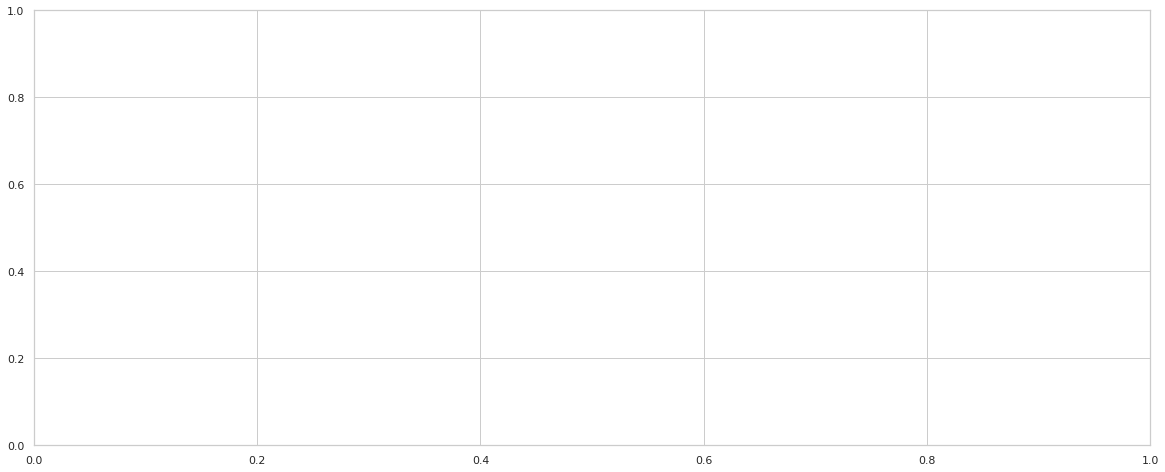

In [17]:
path = '/media/andrey/My Passport/Andrey/DataAnalysis/meta_recordings.xlsx'

#animals = [375270, 375280, 375290, 375300, 37527, 37528, 37529, 37530, 48, 51, 53, 0]

#animals =[451,453,551,553,653,651,400,501,600]

rec = [28]

#rec = np.arange(0,56)
#rec = np.arange(56,134)

#### WHAT TO DO WITH EXCLUDED VALUES???


for r in rec:
    plt.cla()
    Traces, Npils, n_accepted_and_rejected = traces_and_npils(r, path)
    
    
    
    Tm0p7N = Traces - 0.7*Npils
    
    num_cells = np.shape(Traces)[0]
    decay_isol = np.zeros((num_cells))
    decay_no_isol = np.zeros((num_cells))
    n_peaks = np.zeros((num_cells))
    height = np.zeros((num_cells))
    width = np.zeros((num_cells))
    
    integral = np.zeros((num_cells))
    
    fs = 30
    trace_len = np.shape(Traces)[1] / (fs * 60) # in minutes    
    
    recording_lenght = Tm0p7N.shape[1] 
    
    Tm0p7N_skewness = skew(Tm0p7N,axis=1)
    
    baseline = np.quantile(Tm0p7N,0.25,axis=1)
    
    Baseline_subtracted = Tm0p7N.copy() 

    
    for i in range(Traces.shape[0]):
        
        #if (i<180):
        #    continue 
        #if (i>100):
        #    break
    
    #for i in range(Baseline_subtracted.shape[0]):  
        
        Baseline_subtracted[i,:] -= baseline[i]
        
        integral[i] = Baseline_subtracted[i,:].sum()/recording_lenght
        
        neuron = i
        
        #N=3
        #Tm0p7N[neuron, ] = np.convolve(Tm0p7N[neuron, ], np.ones((N,))/N, mode='same')
        
        c, s, b, decay_neuron_isolated10, _ = deconvolve(np.double(Tm0p7N[neuron, ]),
                                                                 penalty = 0, sn=25, optimize_g = 10)
        _, _, _, decay_neuron_no_isolated, _ = deconvolve(np.double(Tm0p7N[neuron, ]), sn=25,
                                                                  penalty = 0)
        
        
        #ARcoef = estimate_time_constant(Tm0p7N[neuron, ], p=2, sn=None, lags=10, fudge_factor=1.0, nonlinear_fit=False)
        
        #print(ARcoef)
    
        peak_ind, peaks = signal.find_peaks(Baseline_subtracted[neuron,:], height = 200,
                                         distance = 10, prominence = 200,
                                         width = (None, None),
                                         rel_height = 0.9)
        
    
        decay_isol[neuron] = - 1 / (fs * np.log(decay_neuron_isolated10))
        decay_no_isol[neuron] = - 1 / (fs * np.log(decay_neuron_no_isolated))
    
        #print(decay_neuron_isolated10,decay_isol[neuron]," s")

    
        n_peaks[neuron] = len(peaks['peak_heights']) / trace_len
    
        if n_peaks[neuron] > 0:
            height[neuron, ] = np.median(peaks['peak_heights'])
            width[neuron, ] = np.median(peaks['widths'])
        else:
            height[neuron, ] = 0
            width[neuron, ] = 0
            
        print(decay_isol[neuron]," s")
        #integral = Baseline_subtracted.sum(axis=1)/recording_lenght
          
        plt.plot(Traces[i,:],color='r',alpha=0.1,label='Trace')
        plt.plot(Npils[i,:],color='b',alpha=0.1,label='Npils')
        plt.plot(Tm0p7N[i,:],color='k',alpha=0.9,label='Trace - 0.7 Npils')
        plt.plot(np.array([baseline[i]+200]*Traces[i,:].shape[0]),color='k',linewidth=1,linestyle='--',alpha=1,label='threshold')
        
        
        plt.plot(np.array([b]*Traces[i,:].shape[0]),color='k',linewidth=2,linestyle='--',alpha=0.3,label='baseline')
        
        #plt.plot(Baseline_subtracted[i,:],color='k',alpha=1,label='Baseline_subtracted')
        
        #plt.plot(np.array([200]*Traces[i,:].shape[0]),color='r',linewidth=1,linestyle='--',alpha=1,label='threshold')        
        
        #plt.plot(b+200,''
        
        plt.plot(c+b, color=(1,0,0), label='Deconvolved')
        plt.plot(s, color=(0,0,1), label='Spikes')
        
        plt.plot(peak_ind, peaks['peak_heights'] + baseline[i],'ok')
        '''
        Tm0p7N_midfilt = medfilt(Tm0p7N[i,:],21)
        
        plt.plot(Tm0p7N_midfilt, label="median filtering")
        
        TSreg = TheilSenRegressor(random_state=42)
        x = np.arange(Tm0p7N[i,:].shape[0])
        X = x[:, np.newaxis]
        fit = TSreg.fit(X, Tm0p7N_midfilt) 
        
        print(fit)
        y_pred =  TSreg.predict(X)
        
        plt.plot(np.arange(Tm0p7N[i,:].shape[0]), y_pred, color='w',linewidth=3, label="Theil Sen regression")
        '''
        plt.text(10,Traces[i,:].max()*0.9,"Tm0p7N.skewness:" + str(Tm0p7N_skewness[i]))
        plt.text(10,Traces[i,:].max()*0.8,"decay time (optimize_g = 10), s:" + str(decay_isol[neuron]))
        plt.text(10,Traces[i,:].max()*0.7,"decay time , s:" + str(decay_no_isol[neuron]))
        #plt.text(10,Traces[i,:].max()*0.7,"decay_neuron_no_isolated:" + str(decay_neuron_no_isolated))        
        #plt.text(10,Traces[i,:].max()*0.8,"baseline:" + str(baseline[i]))
        plt.text(10,Traces[i,:].max()*0.6,"integral:" + str(integral[i]))
        plt.text(10,Traces[i,:].max()*0.5,"n_peaks (peak per min):" + str(n_peaks[i]))
        plt.text(10,Traces[i,:].max()*0.4,"n_peaks (per recordings):" + str(n_peaks[i]*trace_len))
        plt.text(10,Traces[i,:].max()*0.3,"height:" + str(height[i]))
        plt.text(10,Traces[i,:].max()*0.2,"width:" + str(width[i]))
        plt.ylim([0,Traces[i,:].max()])
        
        
        plt.xlim([0,Traces[i,:].shape[0]])
        plt.legend()
        plt.show()
        #plt.savefig(str(r) + '/' + str(i) + ".png")
        plt.cla()
    

In [232]:
TheilSenRegressor?

571.3917541503906
144.33082950860614


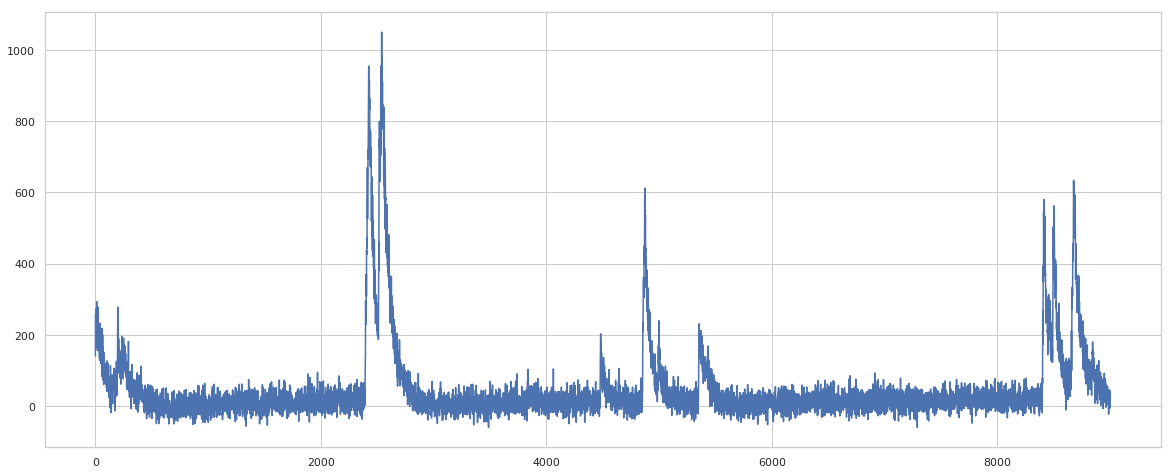

In [43]:
neuron = 7
plt.plot(Baseline_subtracted[neuron,:])
print(height[neuron])
print(width[neuron])
plt.show()

In [ ]:
0.559416946042869  s
0.5938741144599826  s
0.6646100208815595  s
0.5318857187507956  s
0.7082704863724683  s
1.0577960356458858  s
1.9795117379385168  s
0.7776522268329311  s
0.6918458700333666  s
0.6993911830511421  s
33.31666388749909  s

In [175]:
np.convolve?

In [ ]:
palette=['g','r','y','b']

In [188]:
palette=None

In [9]:
recmax = max(rec)
recmin = min(rec)
print(recmin,recmax)

0 49


In [8]:
 str(np.unique(df_npil_stat['animal']))

'[400 451 453 501 551 553 600 651 653]'

# Analysis of awake-isoflurane-awake 

In [149]:
df_npil_stat_newdata = df_npil_stat[(df_npil_stat['animal']==400)|(df_npil_stat['animal']==501)|(df_npil_stat['animal']==600)]

In [143]:
#df_npil_stat_newdata = df_npil_stat[(df_npil_stat['recording']==269)|(df_npil_stat['recording']==270)|(df_npil_stat['recording']==271)|(df_npil_stat['recording']==272)]

In [122]:
df_corr_newdata = df_corr[(df_corr['animal']==400)|(df_corr['animal']==501)|(df_corr['animal']==600)]

In [45]:
from sklearn.decomposition import PCA

In [106]:
pca = PCA(n_components=6)

In [110]:
X = df_npil_stat_newdata[['Tm0p7N.skewness','integrals','n_peaks','height','width','Tm0p7Ncorr.mean']].to_numpy().copy()
re = df_npil_stat_newdata[['recording']].to_numpy().copy()
re = re[:,0]
#color = ['r' if x==269 else 'b' for x in re[:,0]]
pca.fit(X)
X = pca.transform(X)
#hue = hue[:,0]
#color[:,0].shape

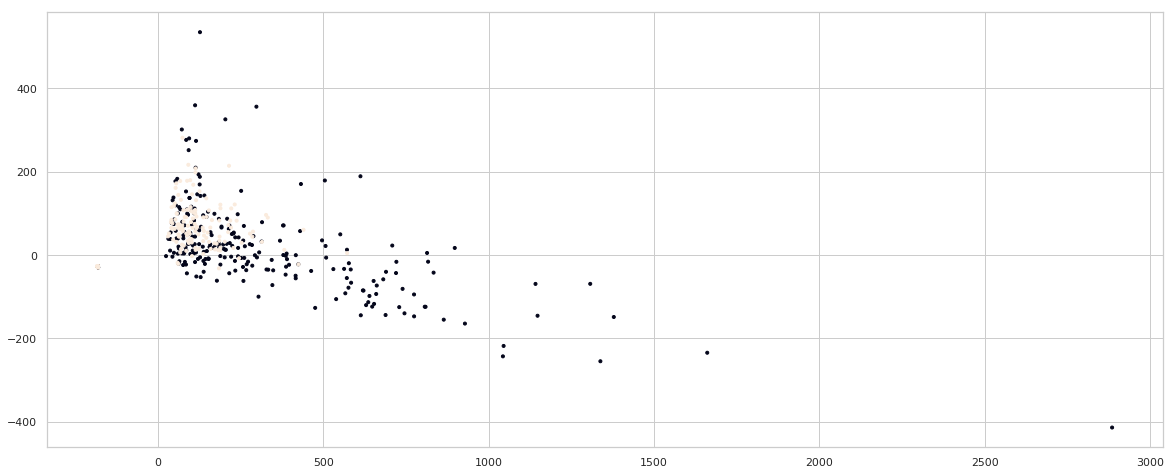

In [111]:
plt.scatter(X[:,0],X[:,1],c=re,marker='.')
#plt.xlim([-25,25])
plt.show()

In [144]:
from sklearn.manifold import TSNE
X = df_npil_stat_newdata[['n_peaks','width','Tm0p7Ncorr.mean']].to_numpy().copy()
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape


(1796, 2)

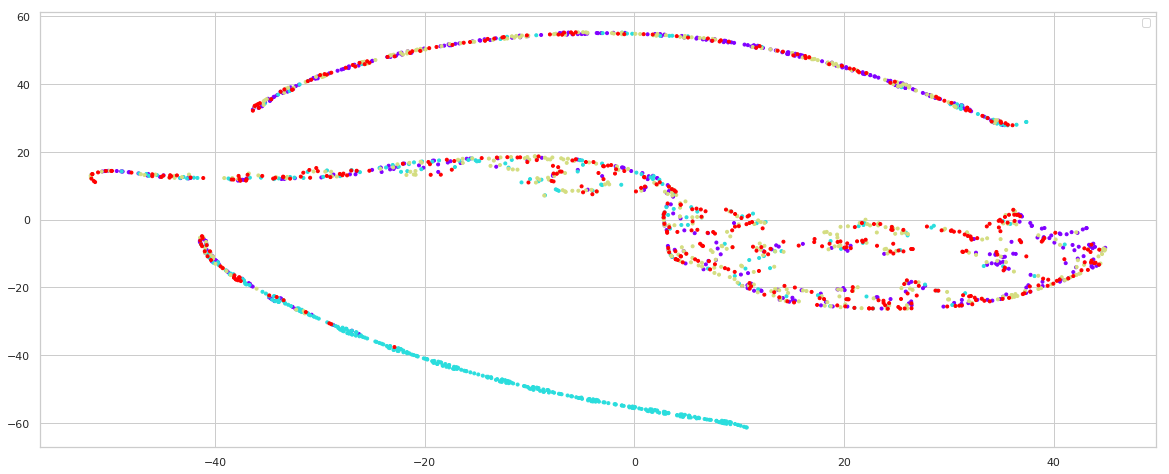

In [146]:
#mpl.rcParams['image.cmap'] = 'jet'

re = df_npil_stat_newdata[['recording']].to_numpy().copy()
re = re[:,0]
cmap = plt.cm.rainbow
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=re,marker='.',cmap=cmap)
#plt.xlim([-25,25])
plt.legend()
plt.show()

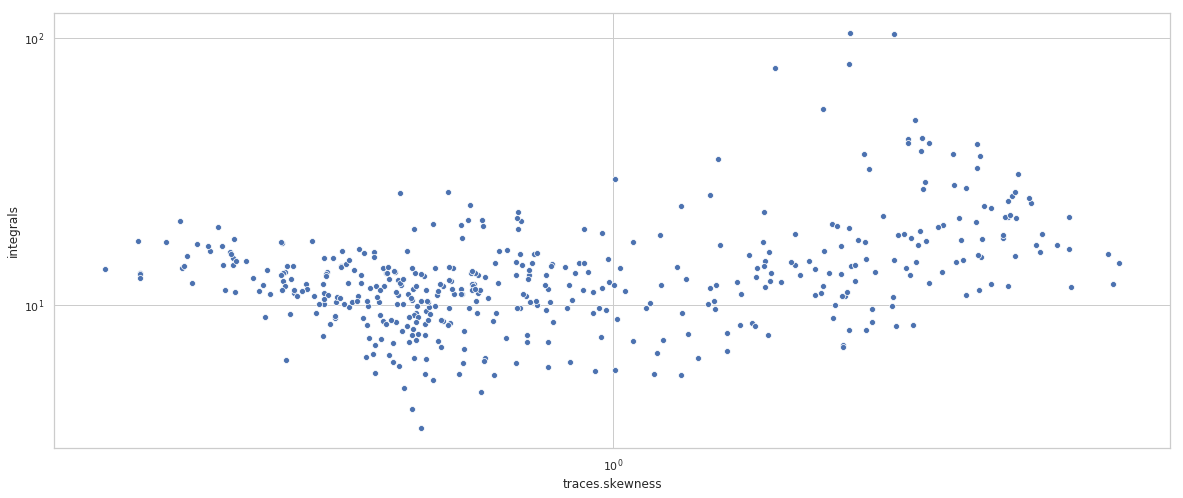

In [225]:
sns.scatterplot(x='traces.skewness',y='integrals',data=df_npil_stat_newdata[df_npil_stat_newdata['recording']==270])
plt.xscale('log')
plt.yscale('log')
#plt.ylim([10,20])
#plt.xlim([0.1,10])
plt.show()

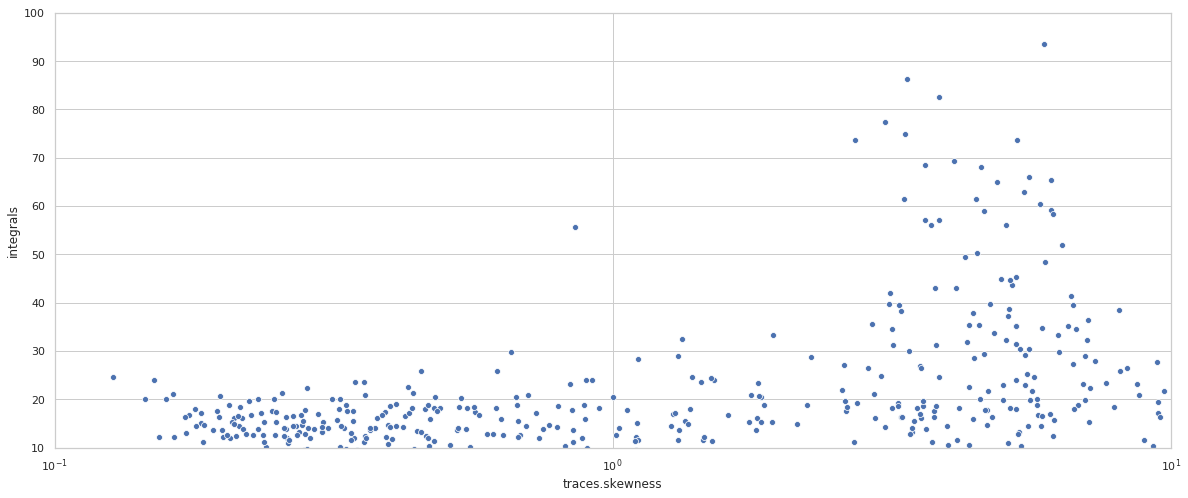

In [222]:
sns.scatterplot(x='traces.skewness',y='integrals',data=df_npil_stat_newdata[df_npil_stat_newdata['recording']==269])
plt.xscale('log')
#plt.yscale('log')
plt.ylim([10,100])
plt.xlim([0.1,10])
plt.show()

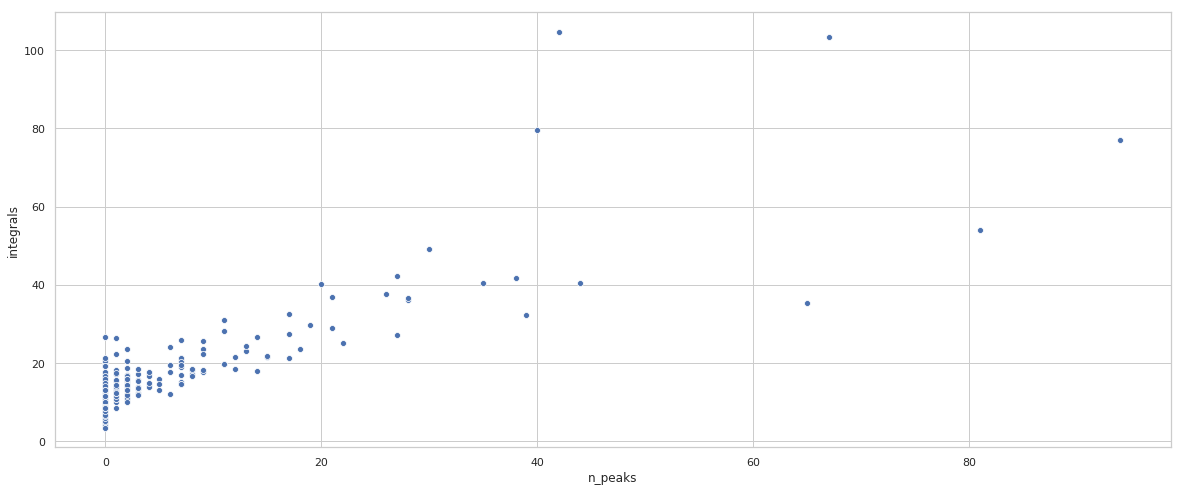

In [96]:
sns.scatterplot(x='n_peaks',y='integrals',data=df_npil_stat_newdata[df_npil_stat_newdata['recording']==270])
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim([0,100])
#plt.xlim([0,2])
plt.show()

In [147]:
data = df_npil_stat_newdata[['Tm0p7N.skewness','integrals','n_peaks','height','width','Tm0p7Ncorr.mean','recording']]
data = data[data['recording']==269]

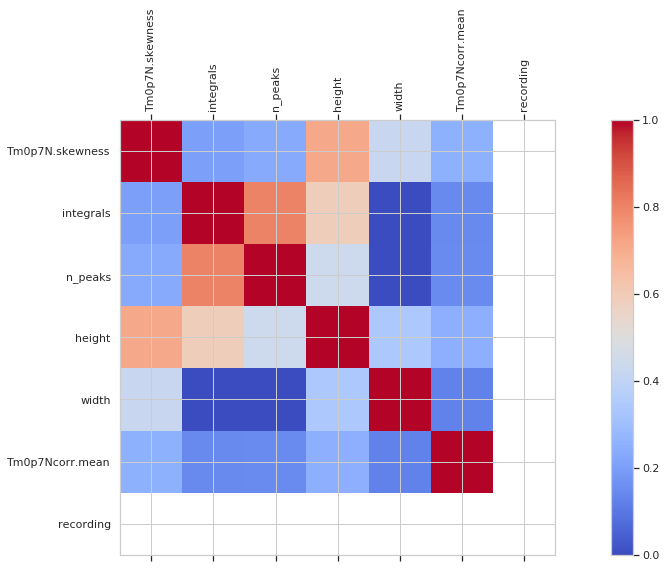

In [148]:
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=0, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [105]:
data.corr()

,Tm0p7N.skewness,integrals,n_peaks,height,width,Tm0p7Ncorr.mean,recording
Tm0p7N.skewness,1.000000,0.394921,0.427508,0.823019,0.671465,0.582361,NaN
integrals,0.394921,1.000000,0.833855,0.630393,0.379370,0.266730,NaN
n_peaks,0.427508,0.833855,1.000000,0.570465,0.318916,0.276414,NaN
height,0.823019,0.630393,0.570465,1.000000,0.854226,0.495566,NaN
width,0.671465,0.379370,0.318916,0.854226,1.000000,0.466230,NaN
Tm0p7Ncorr.mean,0.582361,0.266730,0.276414,0.495566,0.466230,1.000000,NaN
recording,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [270]:
 str(np.unique(df_npil_stat['condition']))

"['awake' 'iso' 'keta' 'keta120' 'keta180' 'keta240' 'keta30' 'keta300'\n 'keta360' 'keta60' 'mmf' 'post120' 'post180' 'post240' 'post30' 'post60'\n 'rec120' 'rec180' 'rec30' 'rec60']"

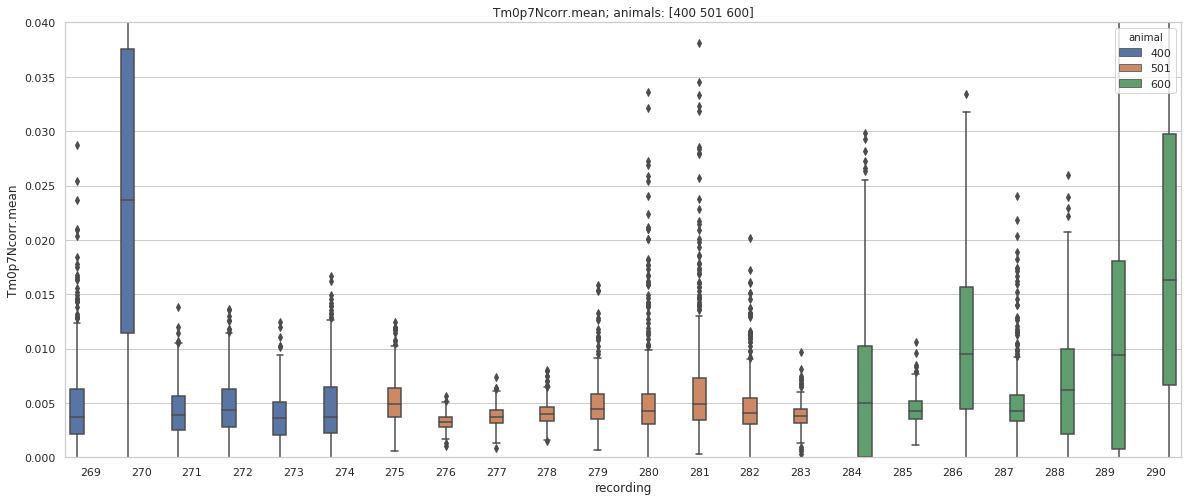

In [16]:
sns.boxplot(x='recording', y='Tm0p7Ncorr.mean',data=df_npil_stat_newdata,hue='animal')
plt.ylim([0,0.04])
plt.title("Tm0p7Ncorr.mean; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

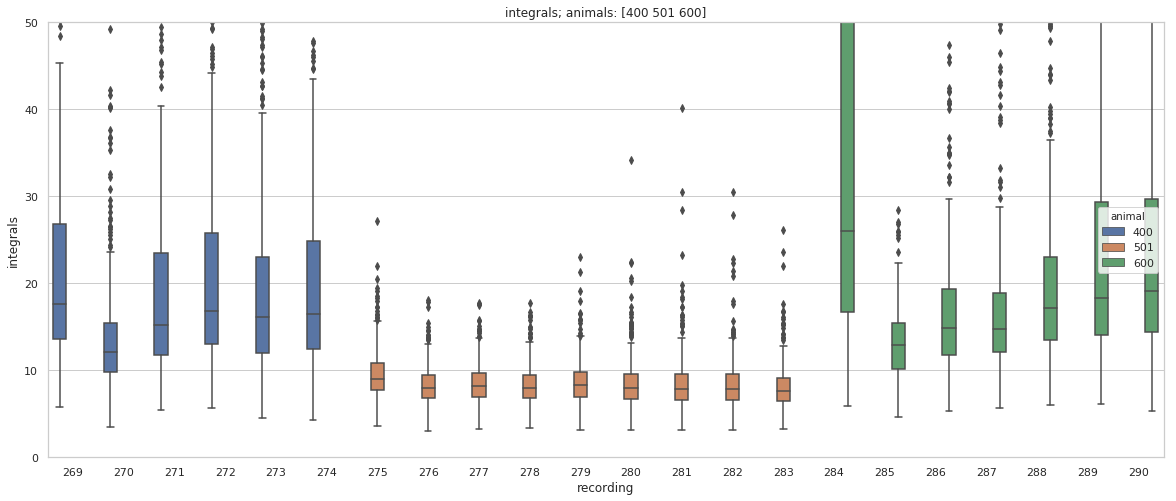

In [14]:
sns.boxplot(x='recording', y='integrals',data=df_npil_stat_newdata,hue='animal')
plt.ylim([0.0,50.0])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("integrals; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

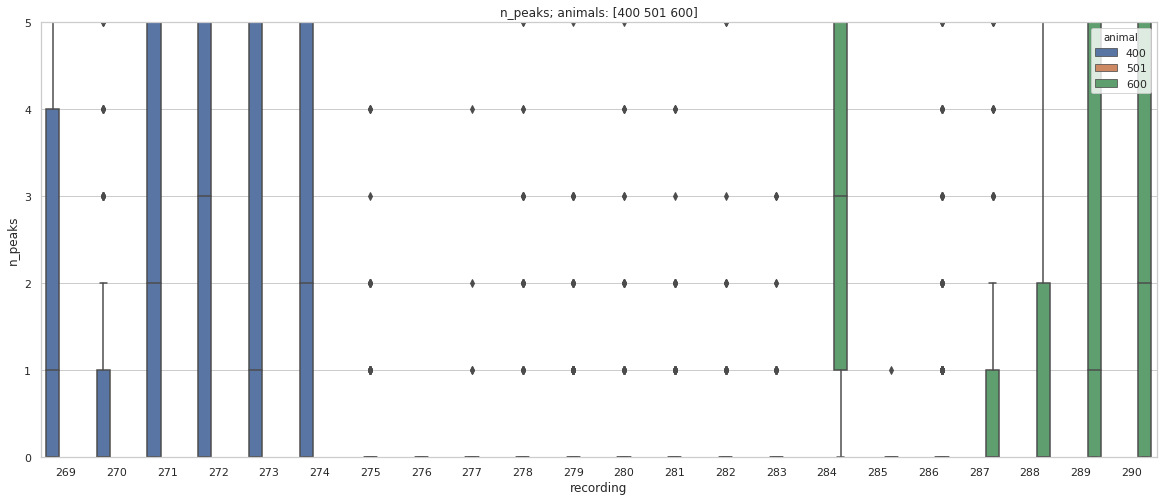

In [154]:
sns.boxplot(x='recording', y='n_peaks',data=df_npil_stat_newdata,hue='animal')
plt.ylim([0.0,5.0])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("n_peaks; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

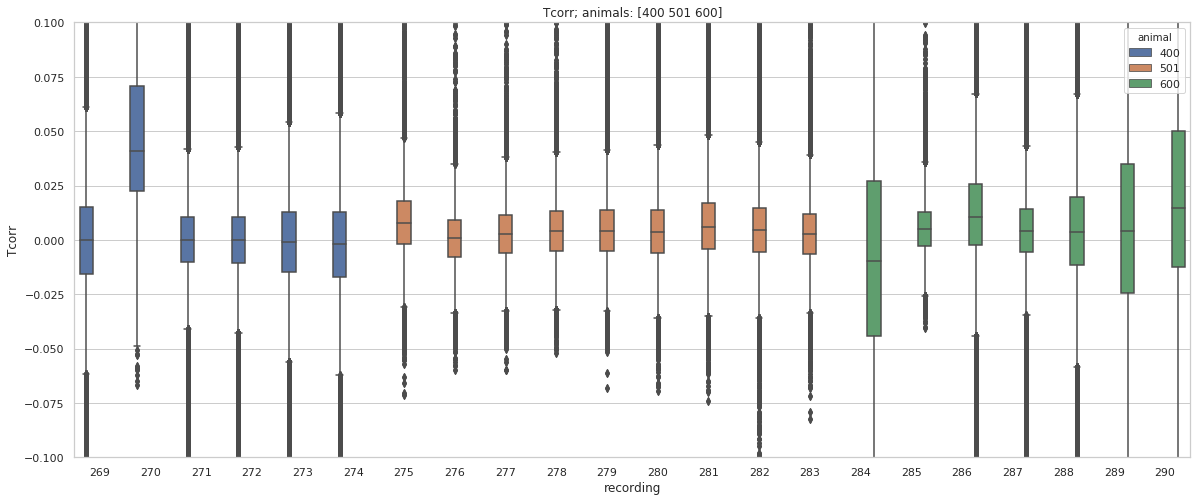

In [53]:
sns.boxplot(x='recording', y='Tcorr',data=df_corr_newdata ,hue='animal')
plt.ylim([-0.1,0.1])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("Tcorr; animals: " + str(np.unique(df_corr_newdata['animal'])))
plt.show()

- For ISO, there are some recovery effects.
- For Keta, it seems that the recovery is lready after 4 hours.
- For MMF, it is 3 and 4 hours


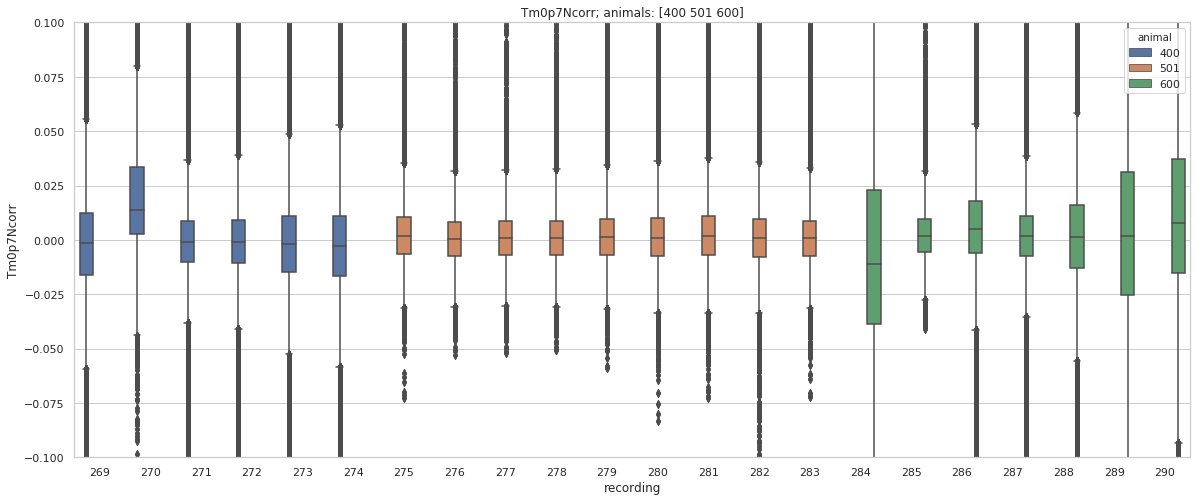

In [19]:
sns.boxplot(x='recording', y='Tm0p7Ncorr',data=df_corr_newdata ,hue='animal')
plt.ylim([-0.1,0.1])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("Tm0p7Ncorr; animals: " + str(np.unique(df_corr_newdata['animal'])))
plt.show()

In [22]:
df_corr_newdata['TcorrmNcorr'] = df_corr_newdata['Tcorr'] - df_corr_newdata['Ncorr']

/home/andrey/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


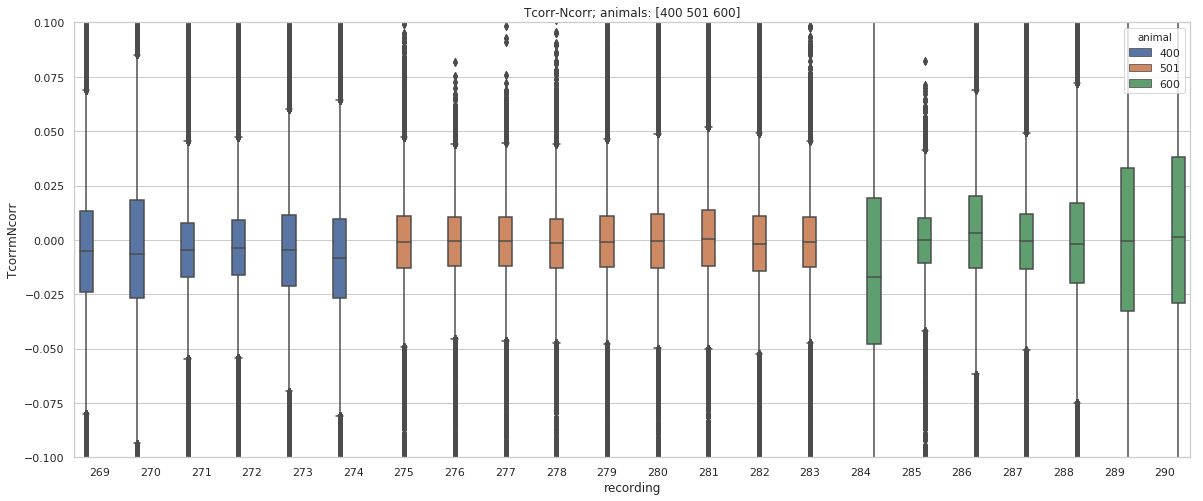

In [24]:
sns.boxplot(x='recording', y='TcorrmNcorr',data=df_corr_newdata ,hue='animal')
plt.ylim([-0.1,0.1])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("Tcorr-Ncorr; animals: " + str(np.unique(df_corr_newdata['animal'])))
plt.show()

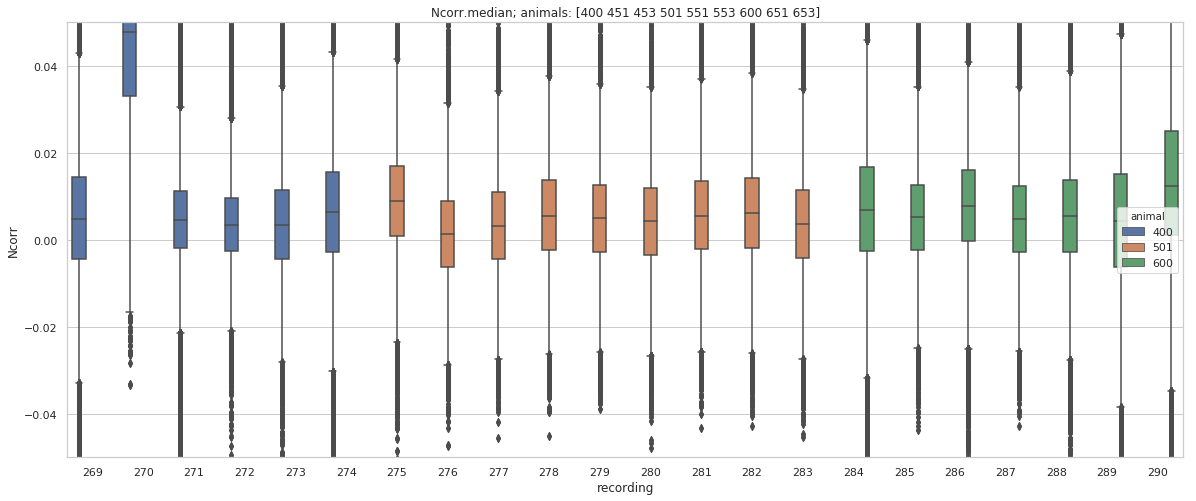

In [54]:
sns.boxplot(x='recording', y='Ncorr',data=df_corr_newdata ,hue='animal')
plt.ylim([-0.05,0.05])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("Ncorr; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

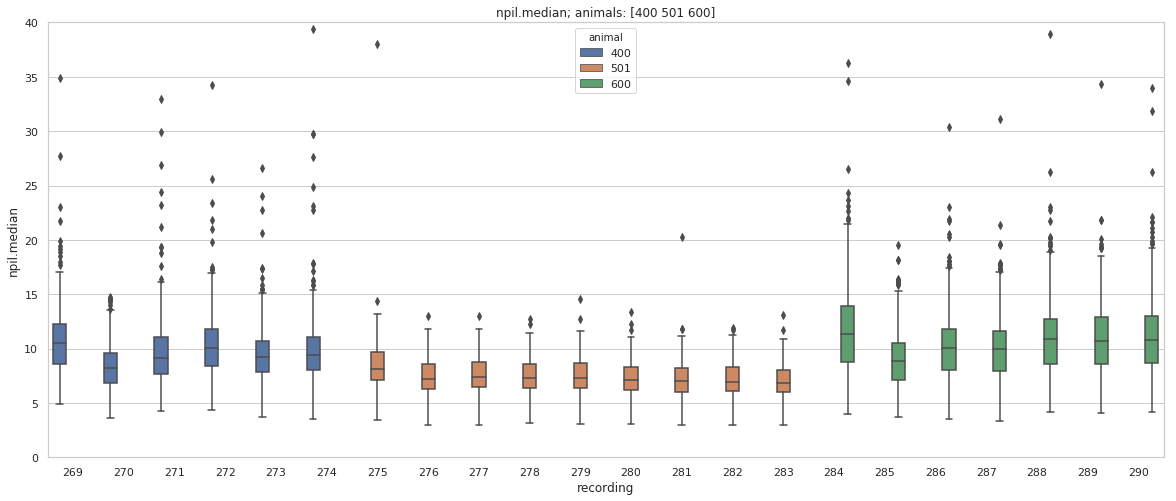

In [41]:
sns.boxplot(x='recording', y='npil.median',data=df_npil_stat,hue='animal')
plt.ylim([0,40.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("npil.median; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

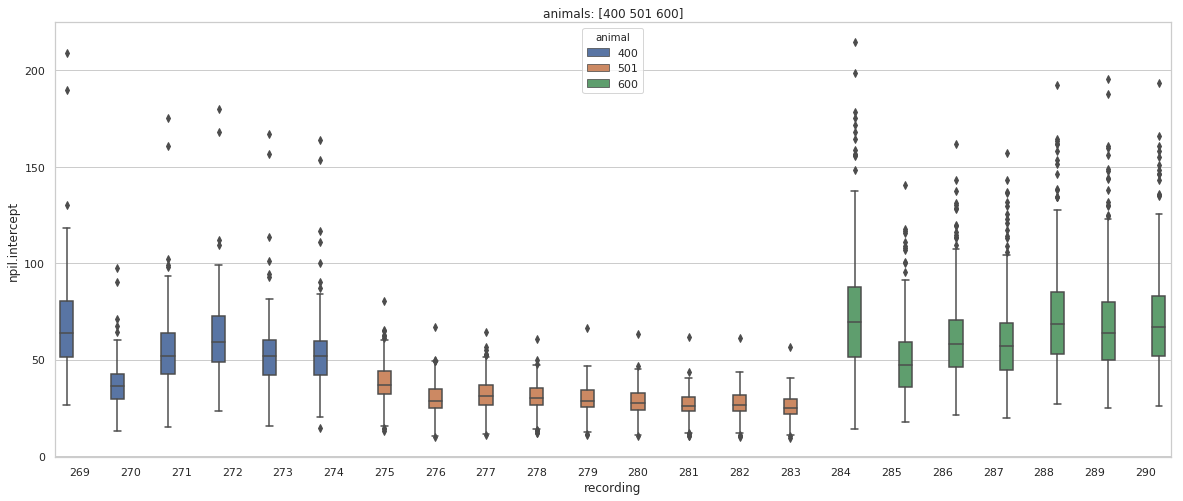

In [23]:
sns.boxplot(x='recording', y='npil.intercept',data=df_npil_stat,hue='animal')
#plt.ylim([0,5.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("animals: " + str(np.unique(df_npil_stat_iso['animal'])))
plt.show()

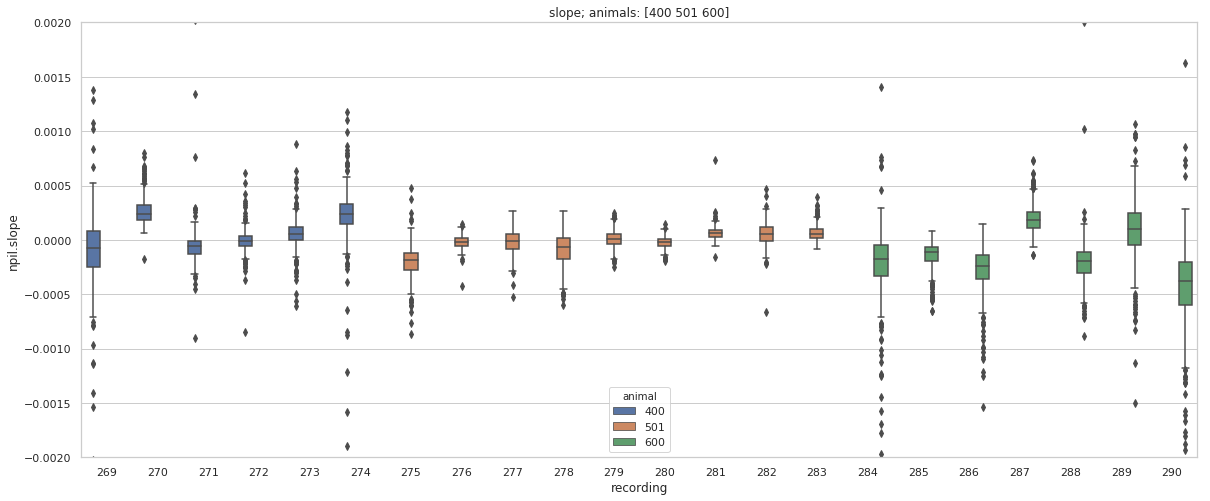

In [24]:
sns.boxplot(x='recording', y='npil.slope',data=df_npil_stat, hue='animal')
plt.ylim([-0.002,0.002])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("slope; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

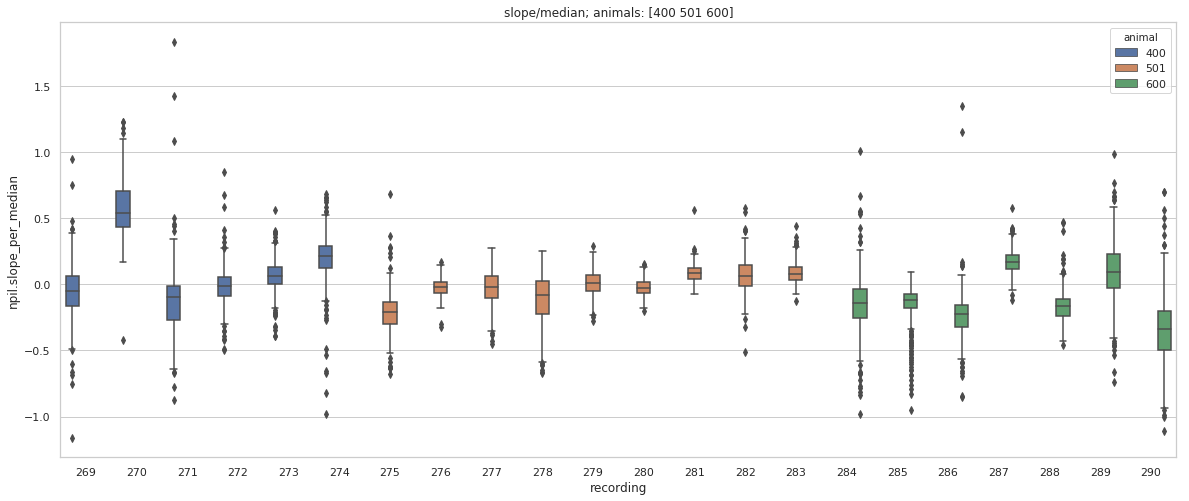

In [34]:
sns.boxplot(x='recording', y='npil.slope_per_median',data=df_npil_stat_newdata,hue='animal')
#plt.ylim([-0.005,0.005])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("slope/median; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

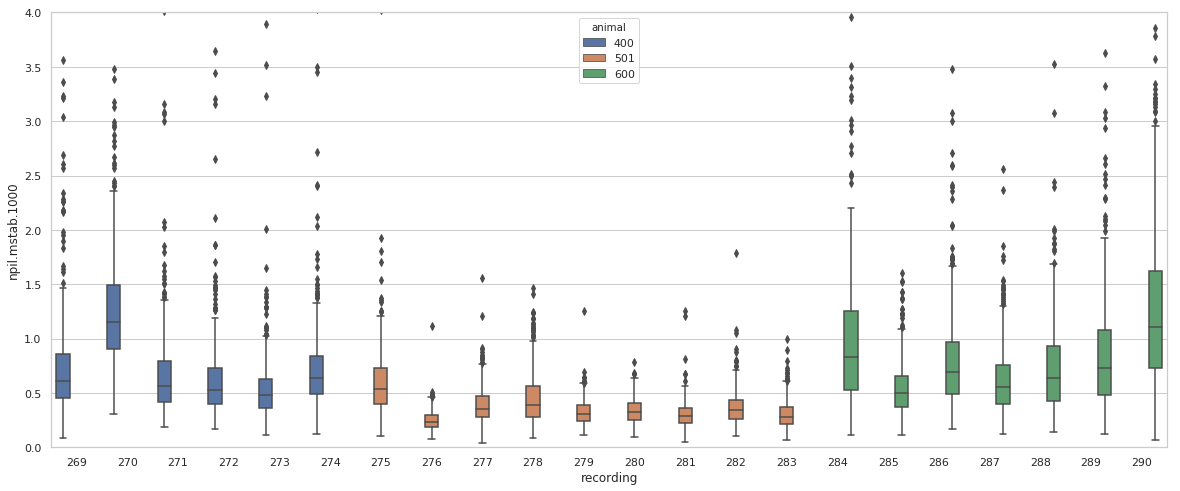

In [19]:
sns.boxplot(x='recording', y='npil.mstab.1000', data=df_npil_stat_newdata,hue='animal')
plt.ylim([0,4.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.show()

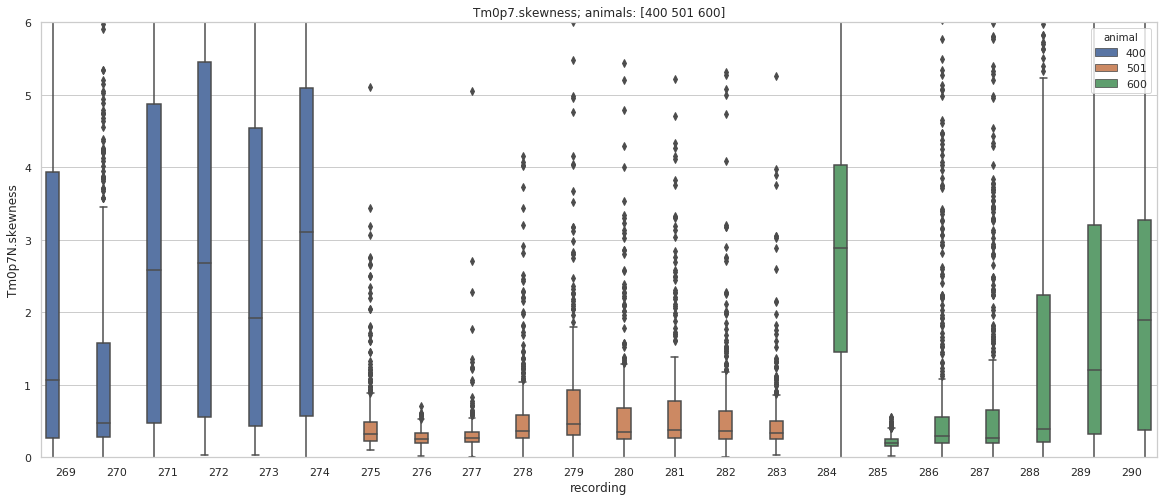

In [54]:
sns.boxplot(x='recording', y='Tm0p7N.skewness',data=df_npil_stat_newdata, hue='animal')
plt.ylim([0,6.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("Tm0p7.skewness; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

In [56]:
sns.boxplot(x='recording', y='npil.residuals',data=df_npil_stat_iso,hue='animal')
plt.yscale('log')
#plt.ylim([0,4.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("slope; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

NameError: name 'df_npil_stat_iso' is not defined

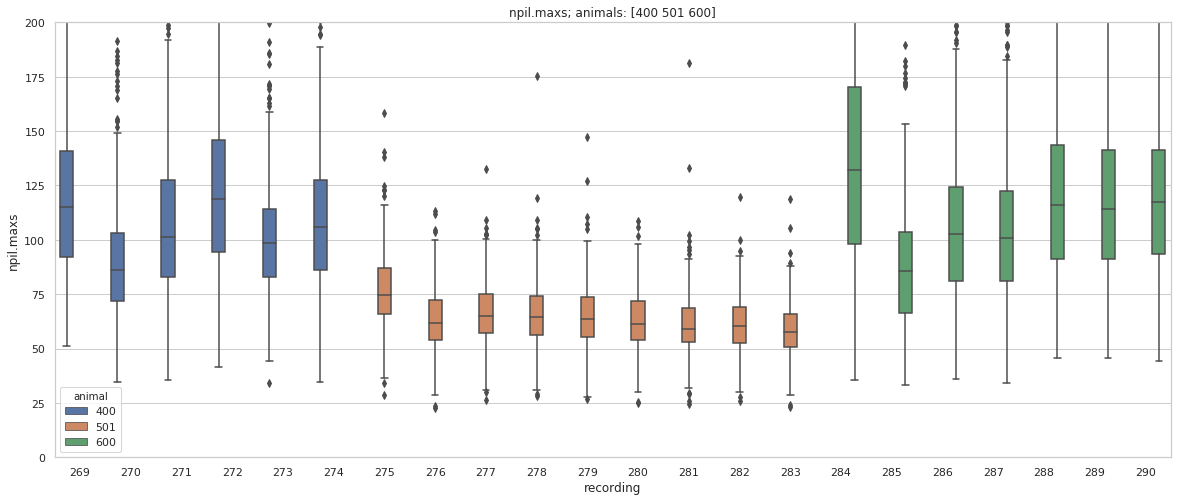

In [24]:
sns.boxplot(x='recording', y='npil.maxs',data=df_npil_stat_newdata,hue='animal')
plt.ylim([-0.005,200])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("npil.maxs; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

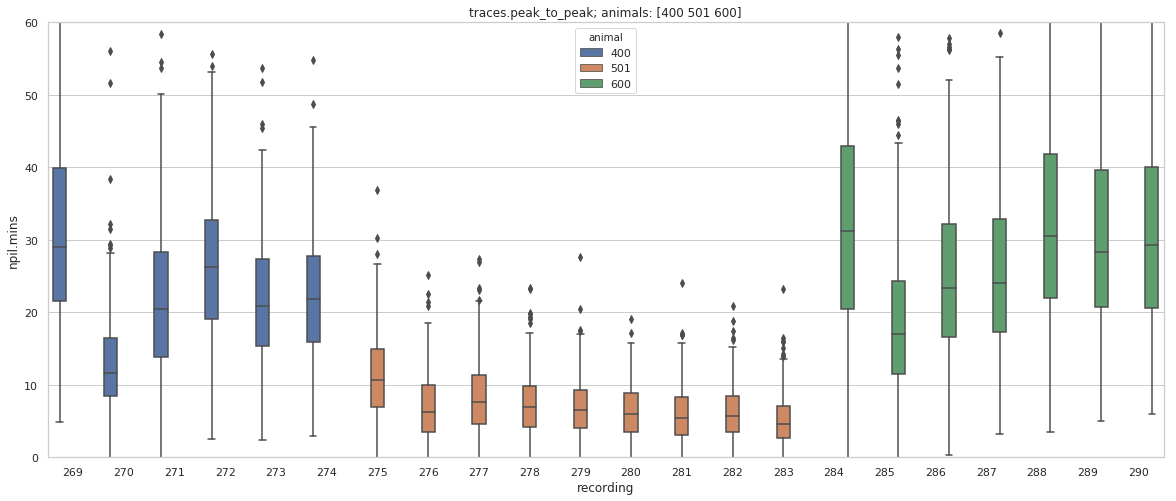

In [27]:
sns.boxplot(x='recording', y='npil.mins',data=df_npil_stat_newdata,hue='animal')
plt.ylim([0,60.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("traces.peak_to_peak; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

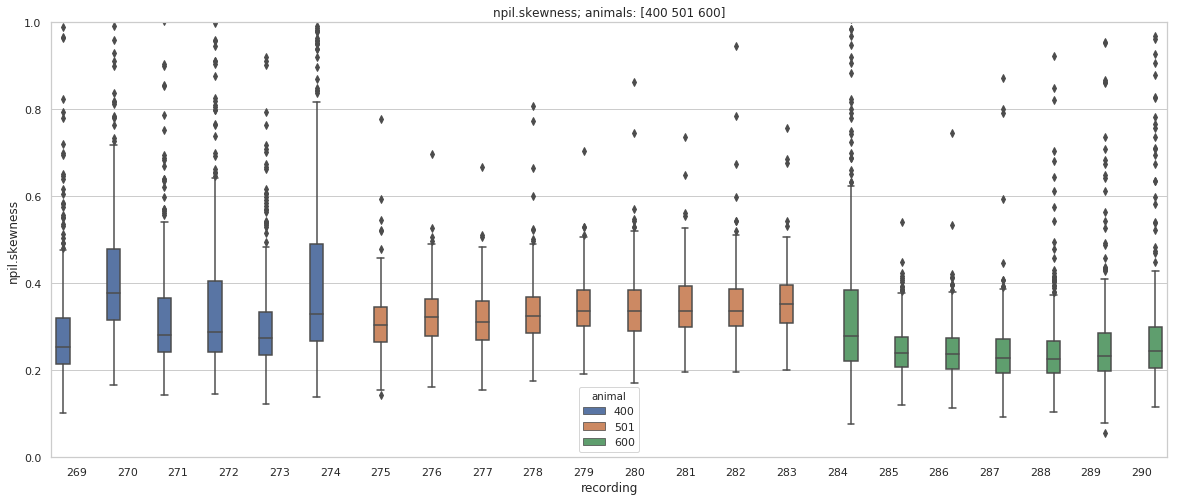

In [57]:
sns.boxplot(x='recording', y='npil.skewness',data=df_npil_stat_newdata,hue='animal')
plt.ylim([0,1.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("npil.skewness; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

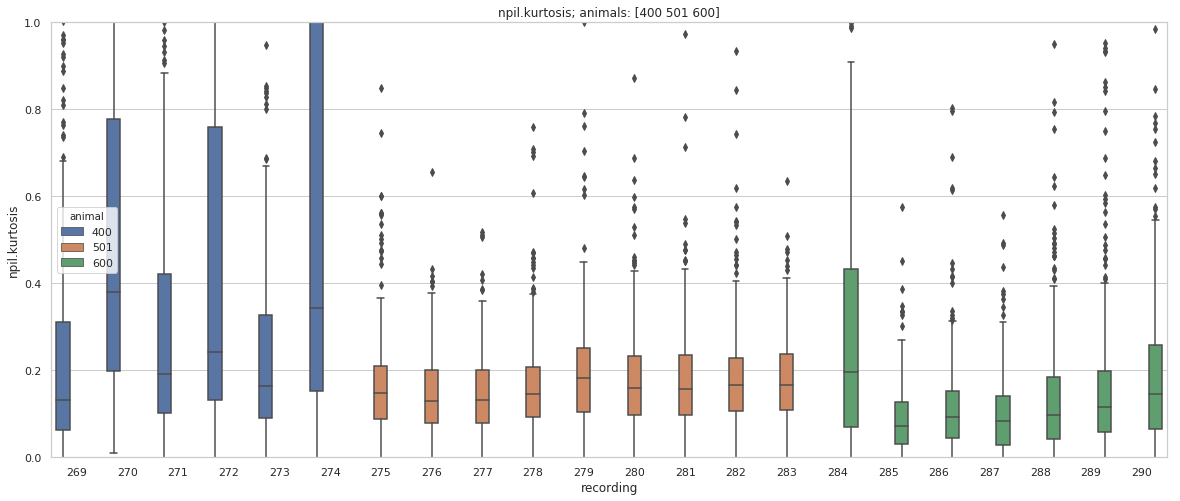

In [58]:
sns.boxplot(x='recording', y='npil.kurtosis',data=df_npil_stat_newdata,hue='animal')
plt.ylim([0.0,1.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("npil.kurtosis; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

### Bleaching?

## Traces

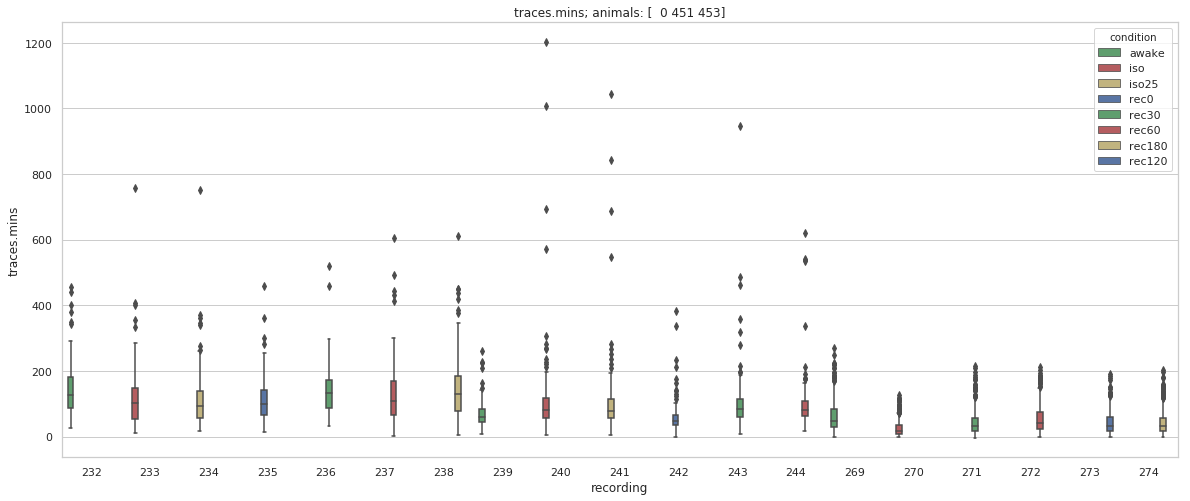

In [27]:
sns.boxplot(x='recording', y='traces.mins',data=df_npil_stat,hue='condition',palette=['g','r','y','b'])
#plt.ylim([0,50.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("traces.mins; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

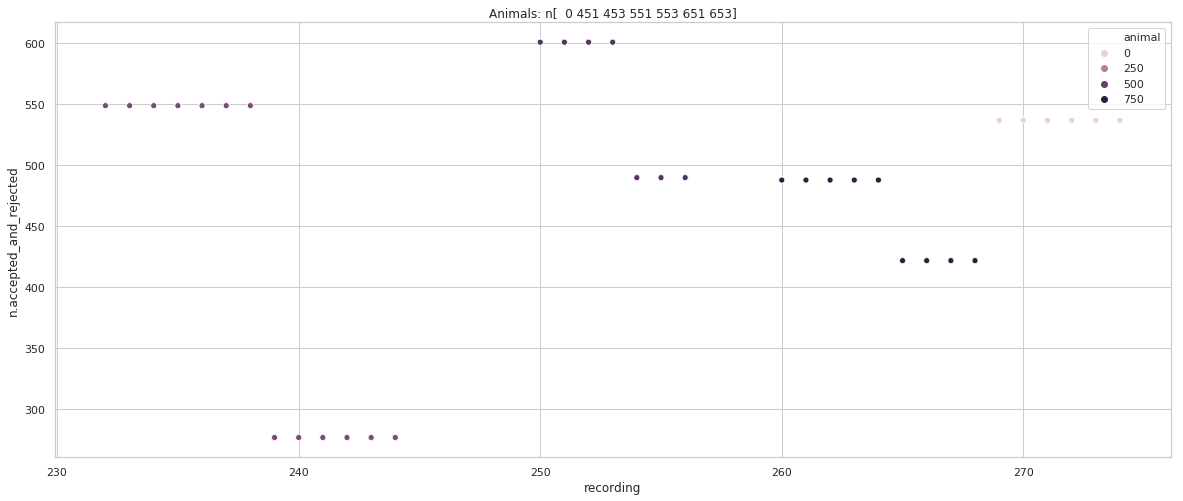

In [226]:
sns.scatterplot(x='recording', y='n.accepted_and_rejected',data=df_npil_stat,hue='animal')
#plt.ylim([0,50.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("Animals: n" + str(np.unique(df_npil_stat['animal'])))
plt.show()

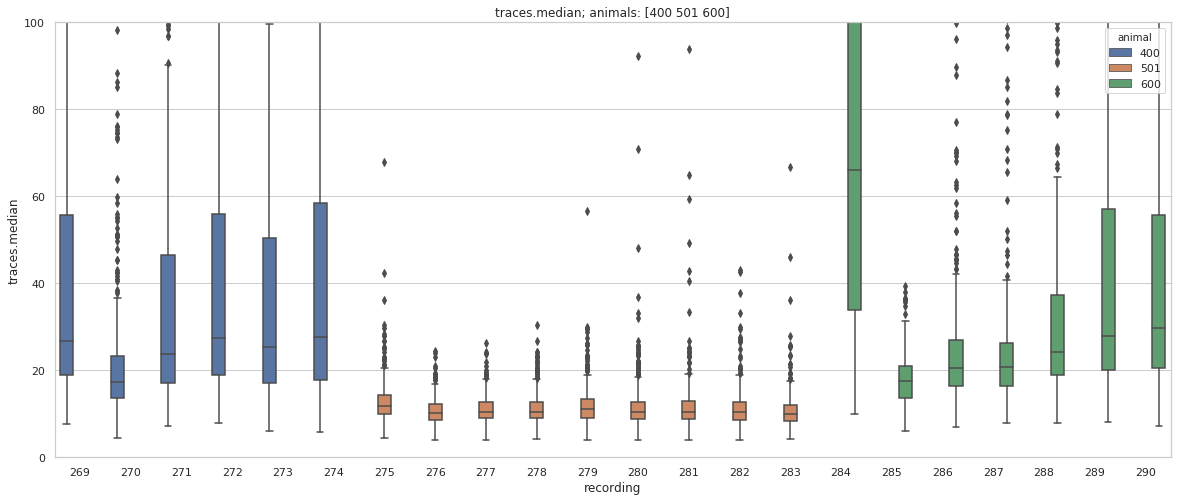

In [30]:
sns.boxplot(x='recording', y='traces.median',data=df_npil_stat, hue='animal')
plt.ylim([0,100.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("traces.median; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

In [31]:
sns.scatterplot(x='recording', y='n.accepted',data=df_npil_stat,hue='condition',palette=palette)
#plt.ylim([0,50.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.show()

NameError: name 'palette' is not defined

In [ ]:
sns.boxplot(x='recording', y='traces.maxs',data=df_npil_stat,hue='condition',palette=['g','r','y','b'])
#plt.ylim([0,50.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("traces.maxs; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

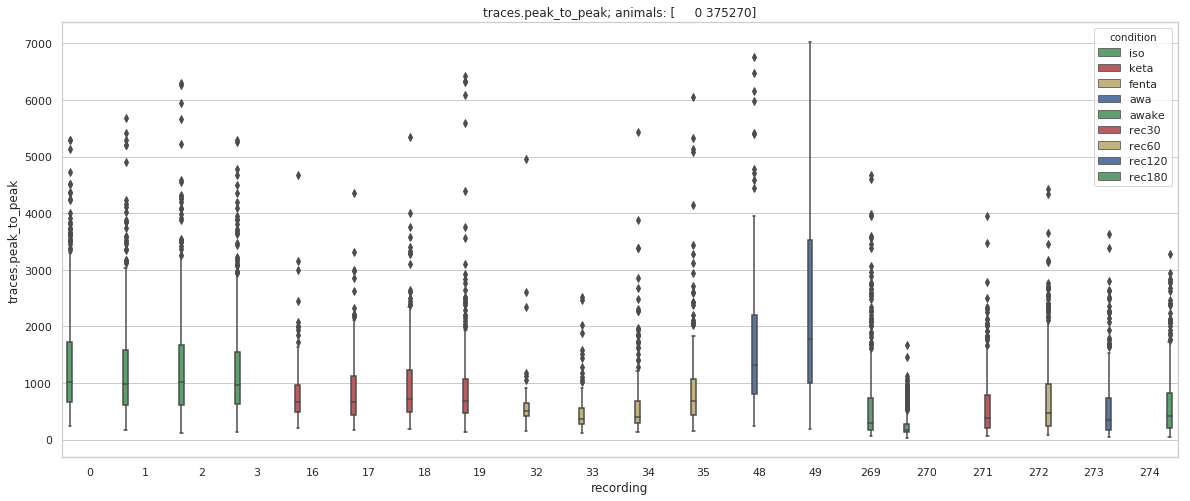

In [175]:
sns.boxplot(x='recording', y='traces.peak_to_peak',data=df_npil_stat,hue='condition',palette=['g','r','y','b'])
#plt.ylim([0,50.])
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".png")
#plt.savefig("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax) + ".eps")
plt.title("traces.peak_to_peak; animals: " + str(np.unique(df_npil_stat['animal'])))
plt.show()

In [508]:
if not os.path.exists("NeuropilStabilityAllRecordings"):
    os.makedirs("NeuropilStabilityAllRecordings")
with open("NeuropilStabilityAllRecordings/df_npil_stat" + str(recmin) + "_" + str(recmax), 'wb') as f:
            pickle.dump(df_npil_stat, f)

In [324]:
np.polyfit?

In [330]:
Npil.shape

(582, 9000)

In [241]:
# ISO - 233, 234

recordings = get_recordings_for_animals(animal, path)

# [233,234,235,236]  

# GOOD RECORDINGS [71,72,73,74,75]

# [4,5,6,7]


Traces_all, Npil_all, Length_all, Nneurons = traces_and_npil_quiet_periods([4,5,6,7],path)
print(Traces_all.shape)
    
    #condition = meta_data['Condition'][recording]
    #recording = meta_data['Recording idx'][recording]

[4, 5, 6, 7]
Recording: 4
Number of neurons: 461
[[335.31744384765625 396.5294494628906 368.6009826660156 ...
  282.8763427734375 326.10394287109375 329.1447448730469]
 [871.3562622070312 968.9166870117188 951.23583984375 ...
  654.9256591796875 555.4401245117188 653.99609375]
 [487.9801330566406 536.7843627929688 523.7507934570312 ...
  437.7186279296875 533.551025390625 449.925048828125]
 ...
 [438.75518798828125 368.5572204589844 431.63800048828125 ...
  358.9425048828125 424.2981872558594 355.584228515625]
 [264.1665344238281 220.53553771972656 252.0595703125 ...
  244.54200744628906 296.2851257324219 254.69554138183594]
 [458.4219665527344 480.02044677734375 518.0316162109375 ...
  429.33953857421875 494.04510498046875 428.8326721191406]]
Recording index:  0
Recording: 5
Number of neurons: 466
[[494.1465759277344 468.7327575683594 489.4663391113281 ...
  511.4170837402344 600.301025390625 504.2122497558594]
 [260.4040832519531 253.6268768310547 182.68345642089844 ...
  277.1772766

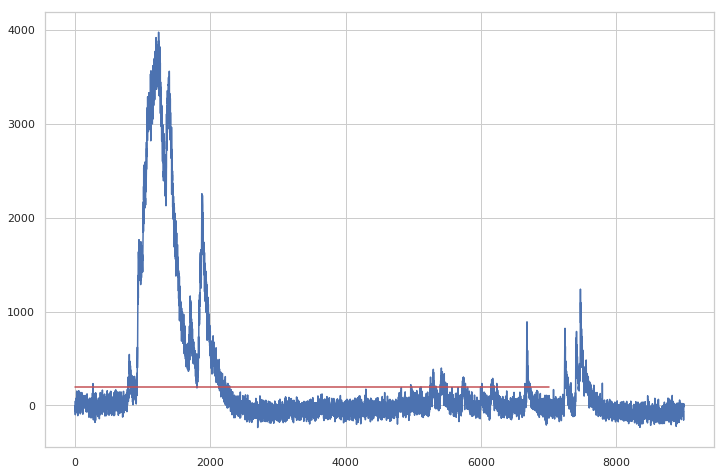

In [258]:
neuron_id = 11

#plt.ylim([-50,200])
plt.plot(Traces_all[neuron_id,:,1],'-b'); plt.plot([0,7000],[200,200],'-r')
plt.show()

In [69]:
Length_all

masked_array(data=[9000., 9000., 9000.],
             mask=False,
       fill_value=1e+20)

ValueError: Lengths must match to compare

In [280]:
path = '/media/andrey/My Passport/Andrey/DataAnalysis/meta_recordings.xlsx'

animals = [375270, 375280, 375290, 375300, 37527, 37528, 37529, 37530, 48, 51, 53]

for animal in animals:
    print(animal)
    print(get_recordings_for_animals(animal, path))
    recordings = get_recordings_for_animals(animal, path)
    
    Traces_all, N_pil_all, Length_all = traces_and_npil_quiet_periods(recordings)

    #condition = meta_data['Condition'][recording]
#    #recording = meta_data['Recording idx'][recording]

375270
0      0
1      1
2      2
3      3
16    16
17    17
18    18
19    19
32    32
33    33
34    34
35    35
48    48
49    49
Name: Number, dtype: int64


TypeError: traces_and_npil_quiet_periods() missing 1 required positional argument: 'path'